In [1]:
%load_ext autoreload
%autoreload 2

from value_iteration import *
from tqdm import tqdm
import numpy as np

Day 7 - Dynamic Programming

## Value Iteration

*

In [2]:
from math import factorial, exp

poissons = {
    2: {},
    3: {},
    4: {},
}

poissons_n_or_more = {
    2: {},
    3: {},
    4: {},
}



def poisson(lmbd, n):
    res = poissons[lmbd].get(n)
    if res is None:
        res = exp(-lmbd) * ((lmbd ** n) / factorial(n))
        poissons[lmbd][n] = res
    return res


def poisson_n_or_more(lmbd, n):
    res = poissons_n_or_more[lmbd].get(n)
    if res is None:
        res = 1 - sum(poisson(lmbd, m) for m in range(n))
        poissons_n_or_more[lmbd][n] = res
    return res

In [3]:
# A state is turned from a number into the quantities of cars at each location as
# if the number of cars in the first location is rows, and the numbers of cars at
# the second location is rows. So if there are 10 cars at the first location, and
# 7 at the second, it is state 10 * 21 + 7 = 217. The formula is then:
# state = n_cars_1 * 21 + n_cars_2.
num_states = 21 * 21
num_actions = 11
discount = 0.9
lmbd_req1 = 3
lmbd_req2 = 4
lmbd_ret1 = 3
lmbd_ret2 = 2

transitions = np.zeros((num_states, num_states, num_actions))
rewards = np.zeros_like(transitions) - 2 * (np.abs(np.arange(-5, 6)) - np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]))
policy = np.ones((num_states, num_actions), dtype=float) / num_actions

for s in tqdm(range(num_states), desc="s"):
    # Number of cars in first location
    s1 = s // 21
    # Number of cars in second location
    s2 = s % 21
    for a in range(num_actions):
        raw_cars_moved = a - 5
        cars_moved = min(s1, raw_cars_moved)
        cars_moved = max(-s2, cars_moved)
        c1am = min(20, s1 - cars_moved)
        c2am = min(20, s2 + cars_moved)
        cost = 0
        if c1am > 10:
            cost += 4
        if c2am > 10:
            cost += 4

        expreq1 = 0
        probs1 = np.zeros(21)
        for req1 in range(0, c1am + 1):
            c1areq = c1am - req1
            if c1areq == 0:
                p_req1 = poisson_n_or_more(lmbd_req1, req1)
            else:
                p_req1 = poisson(lmbd_req1, req1)
            expreq1 += req1 * p_req1

            for ret1 in range(0, 21 - c1areq):
                c1aret = c1areq + ret1
                if c1aret == 20:
                    p_ret1 = poisson_n_or_more(lmbd_ret1, ret1)
                else:
                    p_ret1 = poisson(lmbd_ret1, ret1)
                probs1[c1aret] += p_req1 * p_ret1

        expreq2 = 0
        probs2 = np.zeros(21)
        for req2 in range(0, c2am + 1):
            c2areq = c2am - req2
            if c2areq == 0:
                p_req2 = poisson_n_or_more(lmbd_req2, req2)
            else:
                p_req2 = poisson(lmbd_req2, req2)
            expreq2 += req2 * p_req2

            for ret2 in range(0, 21 - c2areq):
                c2aret = c2areq + ret2
                if c2aret == 20:
                    p_ret2 = poisson_n_or_more(lmbd_ret2, ret2)
                else:
                    p_ret2 = poisson(lmbd_ret2, ret2)
                probs2[c2aret] += p_req2 * p_ret2

        for s1_ in range(21):
            for s2_ in range(21):
                s_ = 21 * s1_ + s2_
                transitions[s,s_,a] = probs1[s1_] * probs2[s2_]
                rewards[s,s_,a] += (expreq1 + expreq2) * 10 - cost

s: 100%|███████████████████████████████████████████████████████████████| 441/441 [00:01<00:00, 373.34it/s]


In [4]:
# Sanity check: Going from some state to any other state when taking
# an action should always be 1.
np.sum(transitions[48,:,:], axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [5]:
iterator = ValueIteration(transitions, rewards, discount, policy)
iterator.find_optimal_policy()
visual_policy = np.argmax(iterator.policy, axis=2).reshape((21, 21)) - 5

Text(46.25, 0.5, 'Cars at location 1')

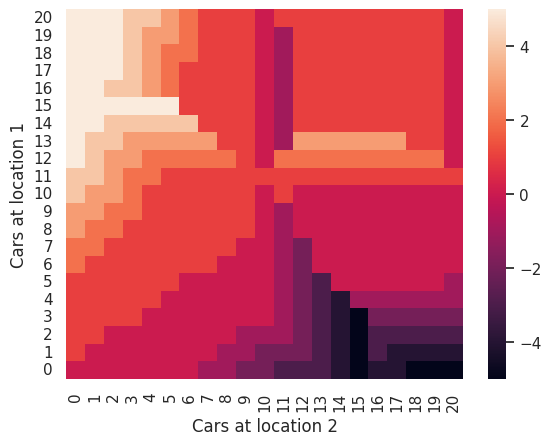

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

f, ax = plt.subplots()
sns.heatmap(visual_policy, ax=ax).invert_yaxis()
ax.set_xlabel("Cars at location 2")
ax.set_ylabel("Cars at location 1")

Text(46.25, 0.5, 'Cars at location 1')

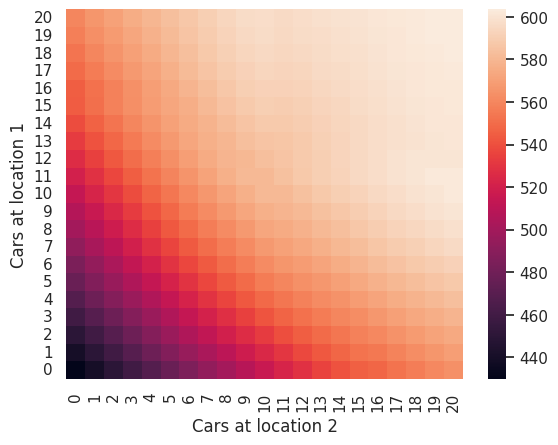

In [7]:
visual_values = iterator.values.reshape((21, 21))
f, ax = plt.subplots()
sns.heatmap(visual_values, ax=ax).invert_yaxis()
ax.set_xlabel("Cars at location 2")
ax.set_ylabel("Cars at location 1")

In [8]:
# Gambler's Problem
goal = 100
# The state space includes the capital, from 1-99, as well as the terminal
# loss and win states of 0 and 100.
num_states = goal + 1
# Bets range from 0 to 50. The gambler can bet more than 50 only if he has
# has that much. But in that case, he needs less than 50 to win, so it is
# pointless to consider those actions.
num_actions = (goal // 2) + 1
transitions = np.zeros((num_states, num_states, num_actions), dtype=float)
rewards = np.zeros_like(transitions, dtype=float)
# Reaching the goal state from any state, using any action, gives a reward
# of 1. We later give a zero probability for reaching the goal state when
# the best is greater than the available capital, eliminating impossible
# strategies, like betting 85 when the capital is 15.
win_reward = 1
loss_penalty = -1
rewards[:,goal,:] = win_reward
rewards[goal,goal,:] = 0
rewards[:,0,:] = loss_penalty
rewards[0,0,:] = 0

# Probability that the coin comes up heads. It may be unfair!
p_h = 0.4
capitals = np.arange(num_states).reshape(num_states, 1, 1)
bets = np.arange(num_actions).reshape(1, 1, num_actions)
targets = np.swapaxes(capitals, 0, 1)
legal_losses = np.asarray(targets - (capitals - bets) == 0)
legal_wins = np.asarray(targets - (capitals + bets) == 0)
transitions = p_h * legal_wins + (1 - p_h) * legal_losses
# Transitions should not be possible when trying to bet more
# than the available capital.
debt = capitals - bets < 0
transitions *= ~debt
# Betting more than available will simply lead to 0 capital.
diagonal = np.eye(num_states, num_actions)
summed_diagonal = debt[:,0,:]
transitions[:,0,:] += summed_diagonal
# The terminal states can only transition to themselves.
transitions[0,:,:] = 0
transitions[goal,:,:] = 0
transitions[0,0,:] = 1.0
transitions[goal,goal,:] = 1.0

In [9]:
assert np.all(rewards[:,1:goal,:] == 0)
assert np.all(rewards[0,0,:] == 0)
assert np.all(rewards[1:,0,:] == loss_penalty)
assert np.all(rewards[goal,goal,:] == 0)
assert np.all(rewards[:goal,goal,:] == win_reward)

assert transitions[15,30,15] == p_h
assert transitions[15,0,15] == 1 - p_h
assert transitions[15,31,15] == 0.0
assert transitions[15,1,15] == 0.0
assert transitions[15,65,50] == 0.0
assert transitions[15,0,50] == 1.0
assert transitions[50,0,50] == 1 - p_h
assert transitions[50,100,50] == p_h
assert np.all(transitions[goal,:goal,:] == 0)
assert np.all(transitions[goal,goal,:] == 1.0)
assert np.all(transitions[0,1:,:] == 0)
assert np.all(transitions[0,0,:] == 1.0)

In [28]:
iterator = ValueIteration(transitions, rewards, discount=4e-3)
iterator.find_optimal_policy()

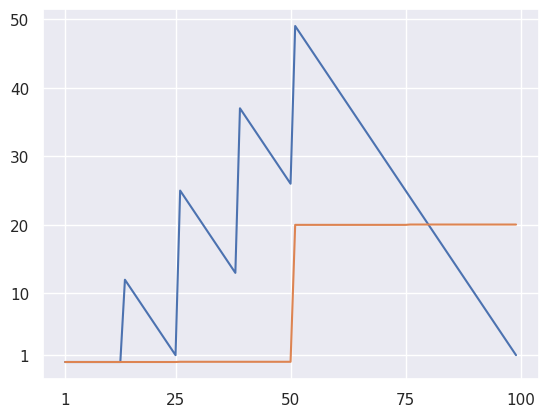

In [29]:
final_policy = np.argmax(iterator.policy, axis=2)[1:goal]
capital = np.arange(1, goal)

plt.plot(capital, final_policy)
plt.plot(capital, iterator.values[1:goal] * 50)
plt.yticks([1, 10, 20, 30, 40, 50])
plt.xticks([1, 25, 50, 75, 100])
plt.show()